# Implementation of the k-means clustering algorithm

## Imports:

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

## K-means clustering algorithm (naive implementation)

Naive implementation of the k-means clustering algorithm.  
__Function:__  
- *k_means()*: Calculate k-means clusters

__Parameters:__  
- *data*: Input array. NumPy array of shape (n_samples, n_features)
- *k*: Number of clusters
- *max_iters (optional)*: Maximum number of iterations (default = 100)
- *random_seed (optional)*: A seed for the initialization function (default = None)
- *init (optional)*: Which initialization function to use (default = random)
      
__Returns:__  
- *centroids*: Final centroids of clusters
- *cluster_labels*: Cluster labels for each data point

In [2]:
def random_init(data, k, random_seed):
    if random_seed is not None:
        np.random.seed(random_seed)
        
    # Random centroids initialization
    return data[np.random.choice(data.shape[0], k, replace=False)]
    
def kmeanspp_init(data, k, random_seed):
    if random_seed is not None:
        np.random.seed(random_seed)
    
    n_samples, n_features = data.shape
    
    # K-means++ initialization
    centroids = [data[np.random.choice(n_samples)]]
    for _ in range(1, k):
        distances = np.array([min([np.linalg.norm(x - c) for c in centroids]) for x in data])
        probabilities = distances / distances.sum()
        centroids.append(data[np.random.choice(n_samples, p=probabilities)])
    return np.array(centroids)

def k_means(data, k, max_iters=1000, random_seed=None, init="random"):        
    if init == "random":
        centroids = random_init(data, k, random_seed)
    elif init == "kmeans++":
        centroids = kmeanspp_init(data, k, random_seed)
    else:
        print("error: 'init' must be a string among 'random' or 'kmeans++'. got '" + init + "' instead")
        
    j = 0
        
    # In the loop, assign each data point to the nearest centroid, then update centroids
    for _ in range(max_iters):
        # Calculates the Euclidean distance from each data point to the each centroid
        dst = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
        # For each node, only assigns it to the centroid it is closest to
        cluster_labels = np.argmin(dst, axis=0)
        
        new_centroids = np.zeros((k, data.shape[1]))
        for i in range(k):
            # Update centroids based on cluster mean
            new_centroids[i] = np.mean(data[cluster_labels == i], axis=0)
        
        # If there are no changes two consecutive runs, break out of the loop
        if np.allclose(centroids, new_centroids):
            j += 1
        else:
            j = 0
        
        # If the new centroids are equal to the old centroids for at least two consecutive runs, stop the execution
        if j >= 2:
            break
            
        centroids = new_centroids
    
    return centroids, cluster_labels

## Automatic k determination

Automatic determination of the optimal k-value. This is done via the so-called elbow method.  
__Functions:__
- *calc_wcss()*: Calculates the wcss (within-cluster sum of squares) for a particular k-means calculation 
- *get_k()*: Finds and returns the optimal k-value using the elbow method by finding the index where the angle of the line becomes lower than a certain specified threshold

In [3]:
def calc_wcss(data, centroids, labels):
    wcss = 0
    for i in range(len(centroids)):
        cluster_points = data[labels == i]
        centroid = centroids[i]
        wcss += np.sum((cluster_points - centroid)**2)
    return wcss

def get_k(data, max_k, threshold=0.1):
    wcss_vals = []
    
    for k in range(1, max_k + 1):
        centroids, labels = k_means(data, k, random_seed=1, init="kmeans++")
        wcss = calc_wcss(data, centroids, labels)
        wcss_vals.append(wcss)
    
    diff = np.diff(wcss_vals)
    diff_r = diff[1:] / diff[:-1]
    for i in range(len(diff_r)):
        k_optimal = i
        if (diff_r[i] < threshold):
            break
    k_optimal += 2 # Add 1 due to np.diff reducing array length by 1 and add 1 due to 0-based indexing
                   # Technically another 1 should be added due to array size reduction, 
                   # but this calculation gives node indexes of the node after the threshold has been hit. 
                   # Therefore, it is necessary to reduce by 1 again so that the algorithm does not overshoot
    
    plt.figure(figsize=(7,5))
    plt.plot(range(1, max_k + 1), wcss_vals)
    linelabel = "Optimal k: " + str(k_optimal)
    plt.axvline(x=k_optimal, color='r', label=linelabel, alpha=0.4)
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("WCSS")
    plt.title("Elbow method")
    plt.legend()
    plt.show();
    
    return k_optimal

## Sample usage (real data - population dynamics 1995-2022)

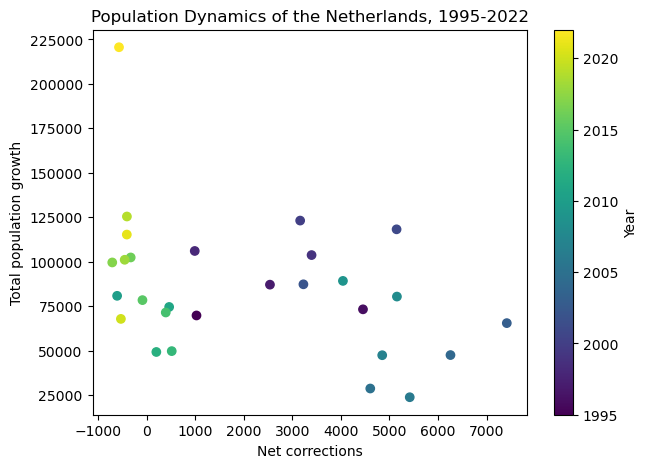

In [4]:
data = np.loadtxt('./Population_dynamics_netherlands_1995-2022.csv', delimiter=';', skiprows=1, dtype=int, encoding=None)
X = data[:, [6, 7]]
X_normalized = (X - X.mean(axis=0)) / X.std(axis=0)
X_years = data[:, 0]

plt.figure(figsize=(7,5))
plt.scatter(X[:, 0], X[:, 1], c=X_years, cmap='viridis')
cbar = plt.colorbar()
cbar.set_label('Year')    
plt.title("Population Dynamics of the Netherlands, 1995-2022")
plt.xlabel("Net corrections")
plt.ylabel("Total population growth")
plt.show();

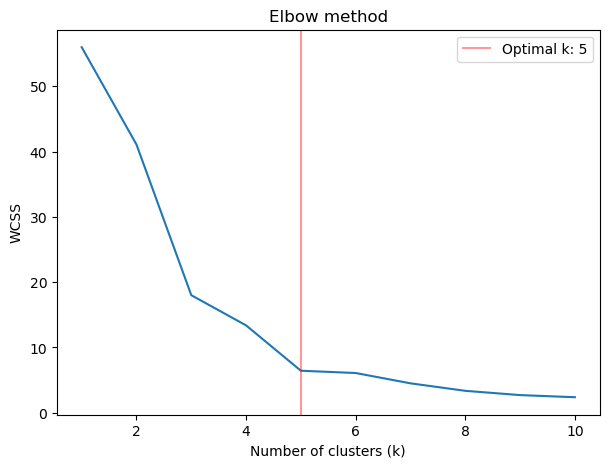

Optimal K:  5


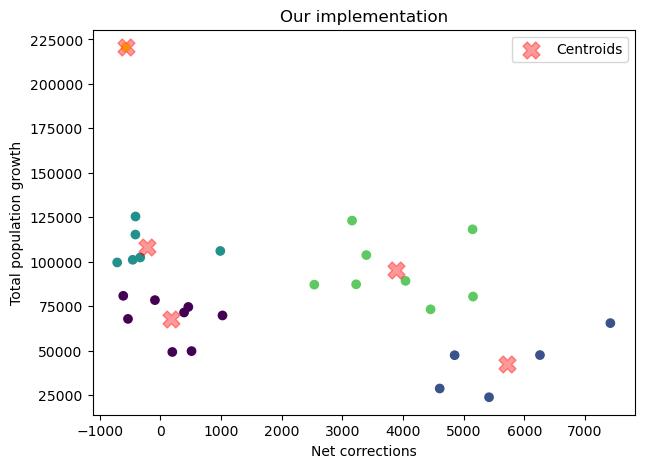

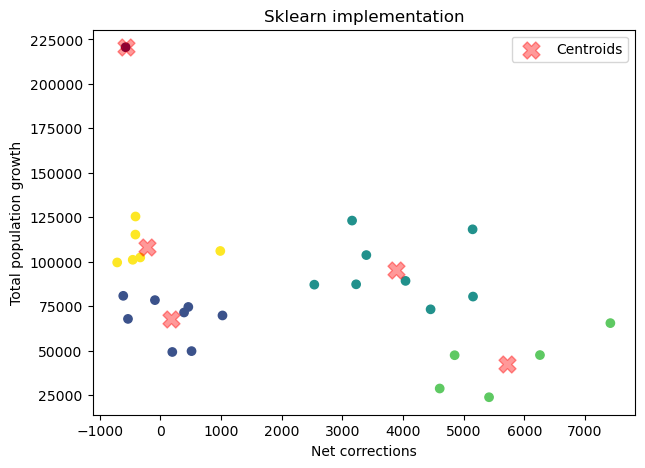

In [5]:
# Set initial random seed to 0
np.random.seed(0)

# Define number of clusters (later, make this automatic)
k = get_k(X_normalized, 10)
print("Optimal K: ", k)

# Perform k-means clustering
centroids, labels = k_means(X_normalized, k, 1000, random_seed=None, init='kmeans++')

sk_kmeans = KMeans(n_clusters=k, n_init=10, init='k-means++', random_state=None)
sk_kmeans.fit(X_normalized)
sklearn_labels = sk_kmeans.labels_
sklearn_centroids = sk_kmeans.cluster_centers_

# De-normalize the centroids so that they can be shown in the scatterplot
centroids = centroids * X.std(axis=0) + X.mean(axis=0)
sklearn_centroids = sklearn_centroids  * X.std(axis=0) + X.mean(axis=0)

plt.figure(figsize=(7,5))
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], alpha=0.4, c='red', s=150, marker='X', label="Centroids")
plt.title("Our implementation")
plt.xlabel("Net corrections")
plt.ylabel("Total population growth")
plt.legend()
plt.show();

plt.figure(figsize=(7,5))
plt.scatter(X[:, 0], X[:, 1], c=sklearn_labels)
plt.scatter(sklearn_centroids[:, 0], sklearn_centroids[:, 1], alpha=0.4, c='red', s=150, marker='X', label="Centroids")
plt.title("Sklearn implementation")
plt.xlabel("Net corrections")
plt.ylabel("Total population growth")
plt.legend()

plt.show();

## Test with artificial data

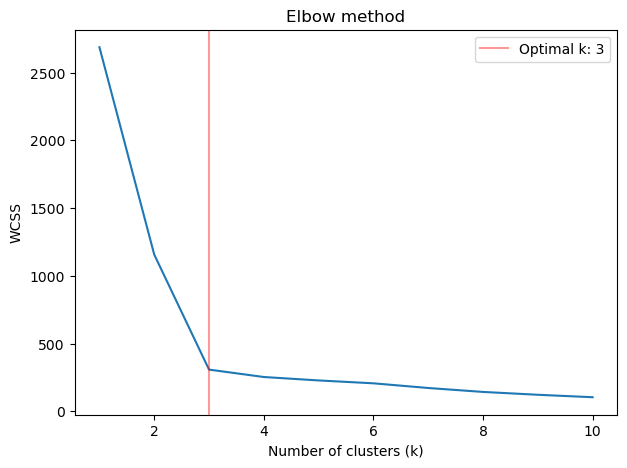

Optimal k:  3


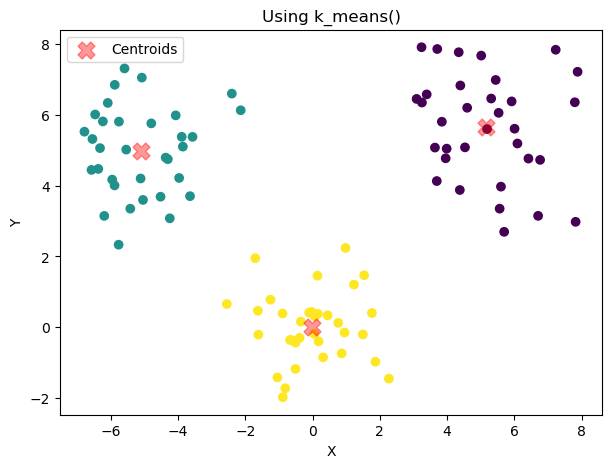

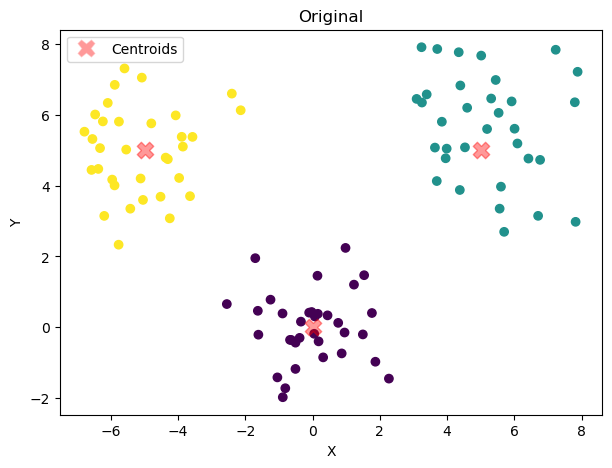

In [6]:
n_samples_a = 100
cluster_centers_a = [(0, 0), (5, 5), (-5, 5)]
cluster_std_a = [1.0, 1.5, 1.2]

Xa, Ya = make_blobs(n_samples=n_samples_a, centers=cluster_centers_a, cluster_std=cluster_std_a, random_state=0)

k_a = get_k(Xa, 10)
print("Optimal k: ", k_a)
centroids_a, labels_a = k_means(Xa, k_a, 1000, random_seed=None, init='kmeans++')

plt.figure(figsize=(7,5))
plt.scatter(Xa[:, 0], Xa[:, 1], c=labels_a)
plt.scatter(centroids_a[:, 0], centroids_a[:, 1], alpha=0.4, c="red", s=150, marker='X', label="Centroids")
plt.title("Using k_means()")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show();

plt.figure(figsize=(7,5))
plt.scatter(Xa[:, 0], Xa[:, 1], c=Ya)
for center in cluster_centers_a:
    plt.scatter(center[0], center[1], marker='X', alpha=0.4, c="red", s=140)
legend_entry = plt.Line2D([0], [0], marker='X', color='w', label='Centroids', markerfacecolor='red', markersize=13, alpha=0.4)
plt.title("Original")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(handles=[legend_entry])

plt.show();

## Test with artificial data (no clear clusters)

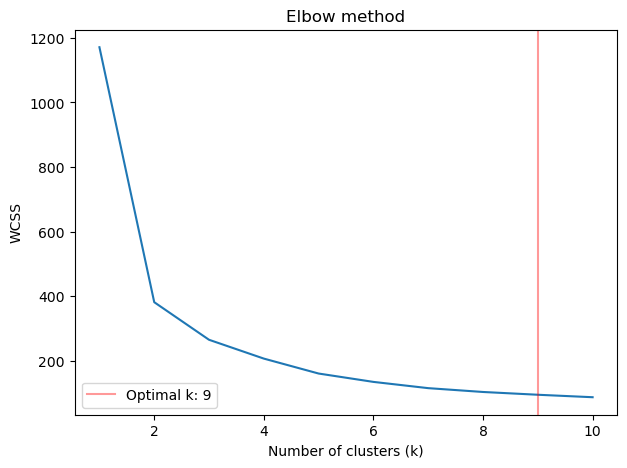

Optimal k:  9


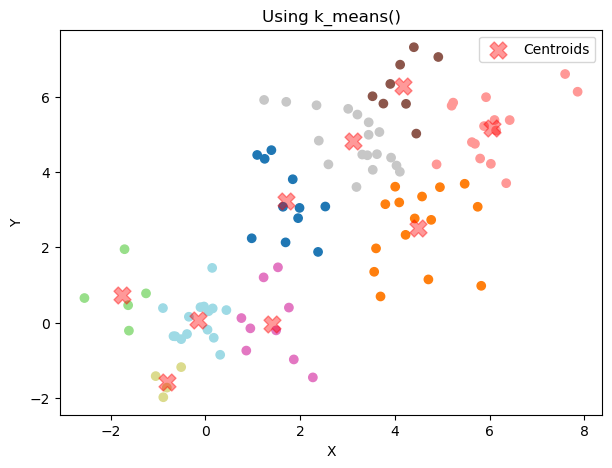

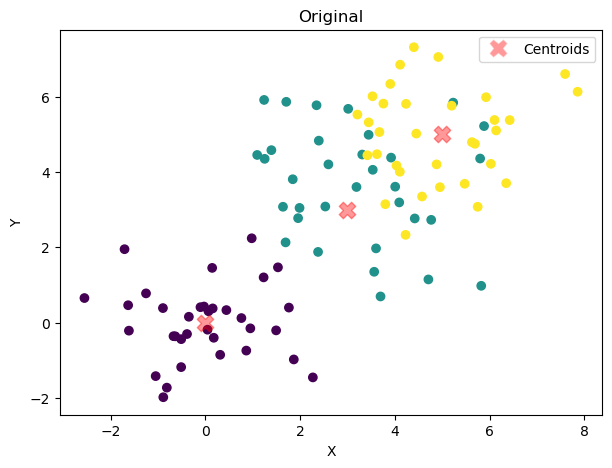

In [7]:
n_samples_b = 100
cluster_centers_b = [(0, 0), (3, 3), (5, 5)]
cluster_std_b = [1.0, 1.5, 1.2]

Xb, Yb = make_blobs(n_samples=n_samples_b, centers=cluster_centers_b, cluster_std=cluster_std_b, random_state=0)

k_b = get_k(Xb, 10)
print("Optimal k: ", k_b)
centroids_b, labels_b = k_means(Xb, k_b, 1000, random_seed=None, init='kmeans++')

plt.figure(figsize=(7,5))
plt.scatter(Xb[:, 0], Xb[:, 1], c=labels_b, cmap='tab20')
plt.scatter(centroids_b[:, 0], centroids_b[:, 1], alpha=0.4, c="red", s=150, marker='X', label="Centroids")
plt.title("Using k_means()")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show();

plt.figure(figsize=(7,5))
plt.scatter(Xb[:, 0], Xb[:, 1], c=Yb)
for center in cluster_centers_b:
    plt.scatter(center[0], center[1], marker='X', alpha=0.4, c="red", s=140)
legend_entry = plt.Line2D([0], [0], marker='X', color='w', label='Centroids', markerfacecolor='red', markersize=13, alpha=0.4)
plt.title("Original")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(handles=[legend_entry])

plt.show();

## Test with real data - House prices Netherlands per province 1995-2023
### Data pre-processing:

   Periods    Regions  Average purchase price (euro)
0     1995  Groningen                          67913
1     1996  Groningen                          72509
2     1997  Groningen                          79297
3     1998  Groningen                          84559
4     1999  Groningen                          96075
1995 -> 0
1996 -> 1
1997 -> 2
1998 -> 3
1999 -> 4
2000 -> 5
2001 -> 6
2002 -> 7
2003 -> 8
2004 -> 9
2005 -> 10
2006 -> 11
2007 -> 12
2008 -> 13
2009 -> 14
2010 -> 15
2011 -> 16
2012 -> 17
2013 -> 18
2014 -> 19
2015 -> 20
2016 -> 21
2017 -> 22
2018 -> 23
2019 -> 24
2020 -> 25
2021 -> 26
2022 -> 27
2023 -> 28
Groningen -> 0
Fryslân -> 1
Drenthe -> 2
Overijssel -> 3
Flevoland -> 4
Gelderland -> 5
Utrecht -> 6
Noord-Holland -> 7
Zuid-Holland -> 8
Zeeland -> 9
Noord-Brabant -> 10
Limburg -> 11


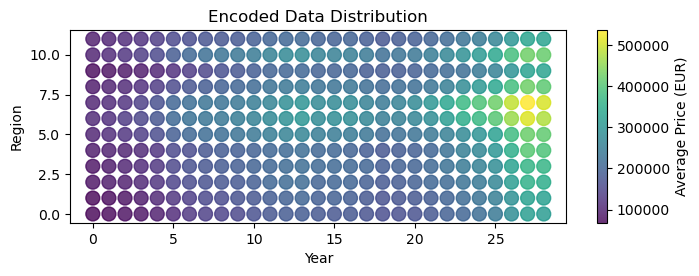

In [8]:
# Data preparation
data = pd.read_csv("./Existing_own_homes__prices__region_netherlands_1995-2023.csv", delimiter=';')
data['Regions'] = data['Regions'].astype(str).apply(lambda x: x.replace(" (PV)", ""))
print(data.head())

label_encoder = LabelEncoder()
data['Years_encoded'] = label_encoder.fit_transform(data['Periods'])
for original_label, encoded_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{original_label} -> {encoded_label}")
    
def get_label_map(data): # Expects a 1-dimensional array
    ordered_dict = {}
    i = 0
    for entry in data:
        if entry not in ordered_dict:
            ordered_dict[entry] = i
            i += 1
    return ordered_dict

label_map = get_label_map(data['Regions'])
data['Regions_encoded'] = data['Regions']
for index, value in data['Regions_encoded'].items():
    data.at[index, 'Regions_encoded'] = label_map[value]
for key, value in label_map.items():
    print(f"{key} -> {value}")
    
# Ensure they are both int
data['Years_encoded'] = data['Years_encoded'].astype(int)
data['Regions_encoded'] = data['Regions_encoded'].astype(int)    
    
# Select features for clustering
X = data[['Years_encoded', 'Regions_encoded', 'Average purchase price (euro)']]

# Convert to NumPy array
X_array = X.to_numpy()

# Extracting columns
years = X_array[:, 0]
regions = X_array[:, 1]
prices = X_array[:, 2]

# Plotting
plt.figure(figsize=(8, 2.5))
plt.scatter(years, regions, s=100, c=prices, cmap='viridis', alpha=0.8)
plt.xlabel('Year')
plt.ylabel('Region')
plt.title('Encoded Data Distribution')
cbar = plt.colorbar()
cbar.set_label('Average Price (EUR)')
plt.show()

# # Standardize the features
scaler = StandardScaler()
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))

# Concatenate scaled prices with other features
X_scaled = np.column_stack((years, regions, prices_scaled))

### Calculating optimal k and k-means:

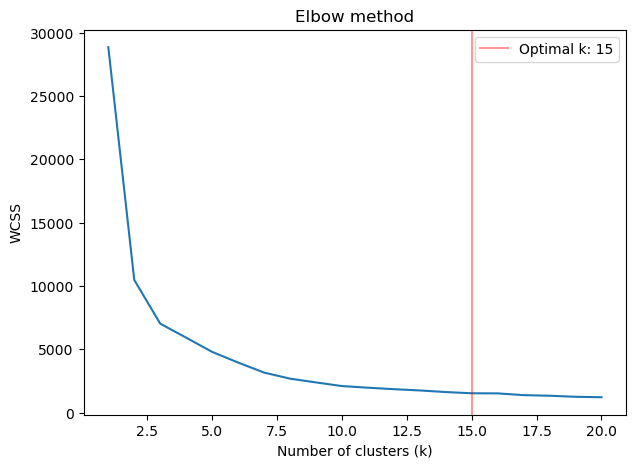

Optimal k:  15


In [9]:
k = get_k(X_scaled, 20)
print('Optimal k: ', k)

centroids, labels = k_means(X_scaled, k, 1000, random_seed=None, init='kmeans++')

sk_kmeans = KMeans(n_clusters=k, n_init=10, init='k-means++', random_state=None)
sk_kmeans.fit(X_scaled)
sklearn_labels = sk_kmeans.labels_
sklearn_centroids = sk_kmeans.cluster_centers_

### Plotting graphs:

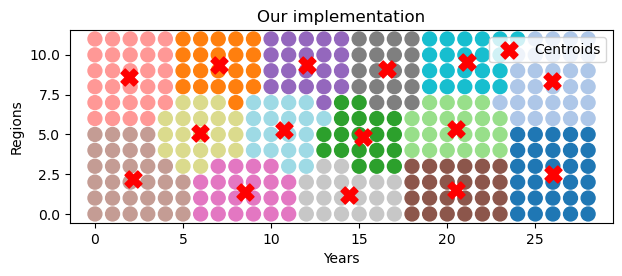

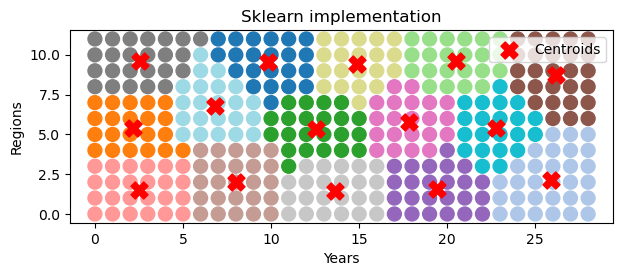

In [10]:
plt.figure(figsize=(7,2.5))
plt.scatter(years, regions, c=labels, s=100, cmap='tab20')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=150, marker='X', label="Centroids")
plt.title("Our implementation")
plt.xlabel("Years")
plt.ylabel("Regions")
plt.legend()
plt.show();

plt.figure(figsize=(7,2.5))
plt.scatter(years, regions, c=sklearn_labels, s=100, cmap='tab20')
plt.scatter(sklearn_centroids[:, 0], sklearn_centroids[:, 1], c='red', s=150, marker='X', label="Centroids")
plt.title("Sklearn implementation")
plt.xlabel("Years")
plt.ylabel("Regions")
plt.legend()
plt.show();

## Differences between random and kmeans++ initialization

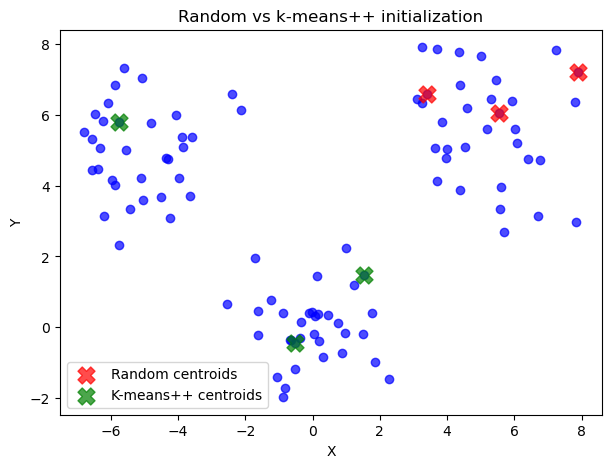

In [11]:
# Take the artificial clusters
# With random_init:
centroids_random_a = random_init(Xa, k_a, None)

# Wtih kmeanspp_init:
centroids_kmeanspp_a = kmeanspp_init(Xa, k_a, None)

plt.figure(figsize=(7,5))

plt.scatter(Xa[:, 0], Xa[:, 1], c='blue', alpha=0.7)
plt.scatter(centroids_random_a[:, 0], centroids_random_a[:, 1], alpha=0.7, c="red", s=150, marker='X', label="Random centroids")
plt.scatter(centroids_kmeanspp_a[:, 0], centroids_kmeanspp_a[:, 1], alpha=0.7, c="green", s=150, marker='X', label="K-means++ centroids")
plt.title("Random vs k-means++ initialization")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()

plt.show();